This script is used to test the database tables.

In [ ]:
import pandas as pd
import sys
import os

from app.db.connection import get_db_connection



: 

In [ ]:
import pandas as pd
import sys
import os

# Ensure we can import from app
script_dir = os.path.dirname(os.path.abspath(__file__))
project_root = os.path.abspath(os.path.join(script_dir, "../../.."))
sys.path.append(project_root)

from app.db.connection import get_db_connection

: 

In [ ]:


DB_PATH = ""
conn = sqlite3.connect(DB_PATH)

def query_table(table_name):
    """Helper to fetch and display table contents as a DataFrame."""
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql_query(query, conn)
    return df

print("Data Testing Environment Ready.")

: 

In [14]:
# View current wallet states
print("--- Wallets Current State ---")
display(query_table("wallets"))


--- Wallets Current State ---


,id,name,provider,type,balance,credit_limit,cycle_day,due_day,color_theme,icon_key,monthly_cashback_limit,cashback_ytd,version,updated_at
0,1,Amore Cashback,BPI,credit,21500.0,50000.0,26,15,from-blue-500 to-indigo-600,None,1000.0,140.0,2,2026-02-02 14:19:00
1,2,EastWest Visa,EastWest,credit,3000.0,100000.0,5,25,from-red-500 to-red-700,None,1500.0,600.0,2,2026-02-02 14:19:00
2,3,Main Savings,BDO,debit,135000.0,NaN,1,1,from-blue-700 to-blue-900,None,0.0,0.0,2,2026-02-02 14:19:00


In [15]:
join_query = """
SELECT 
    h.transaction_date, 
    h.merchant, 
    h.total_amount as header_total,
    d.description,
    d.line_amount,
    d.category_id,
    h.executed_by
FROM transaction_headers h
JOIN transaction_details d ON h.id = d.header_id
ORDER BY h.transaction_date DESC
"""
df_transactions = pd.read_sql_query(join_query, conn)
conn.close()

print("--- Transaction Master View ---")
display(df_transactions)

--- Transaction Master View ---


,transaction_date,merchant,header_total,description,line_amount,category_id,executed_by
0,2026-02-02,Landmark Supermarket,3500.0,Weekly Supplies,3500.0,groceries,user
1,2026-02-02,Wolfgang Steakhouse,12000.0,Birthday Dinner,12000.0,dining,user


In [25]:
import sqlite3
import os
from contextlib import contextmanager

# Path for Cloud Run vs local development
DB_PATH = "/mnt/data/waiswallet.db" if os.getenv("K_SERVICE") else "waiswallet.db"

@contextmanager
def get_db_connection():
    """
    Creates a secure connection to the SQLite database.
    Uses a context manager to ensure the connection is closed automatically.
    """
    conn = None
    try:
        conn = sqlite3.connect(
            DB_PATH, 
            detect_types=sqlite3.PARSE_DECLTYPES | sqlite3.PARSE_COLNAMES,
            check_same_thread=False # Crucial for FastAPI/Asynchronous environments
        )
        # Enable foreign key support (essential for your Header-Detail and Ledger logic)
        conn.execute("PRAGMA foreign_keys = ON;")
        
        # Row factory allows accessing columns by name (e.g., row['balance'])
        conn.row_factory = sqlite3.Row
        
        yield conn
        
    except sqlite3.Error as e:
        print(f"❌ Database connection error: {e}")
        raise
    finally:
        if conn:
            conn.close()

In [26]:
def check_wallet_balance(wallet_id: int):
    with get_db_connection() as conn:
        cursor = conn.cursor()
        cursor.execute("SELECT name, balance FROM wallets WHERE id = ?", (wallet_id,))
        row = cursor.fetchone()
        if row:
            print(f"Wallet {row['name']} has ₱{row['balance']}")

# Testing your EastWest ₱1,500 cap
with get_db_connection() as conn:
    df = pd.read_sql_query("SELECT * FROM wallet_cashback_history", conn)
    display(df)

,id,wallet_id,month_year,amount_earned,monthly_limit,is_capped,created_at,updated_at
0,1,1,2026-02,152.50,1000.0,0,2026-02-02 15:28:11,2026-02-02 15:28:11
1,2,2,2026-02,69.95,1500.0,0,2026-02-02 15:28:11,2026-02-02 15:28:11


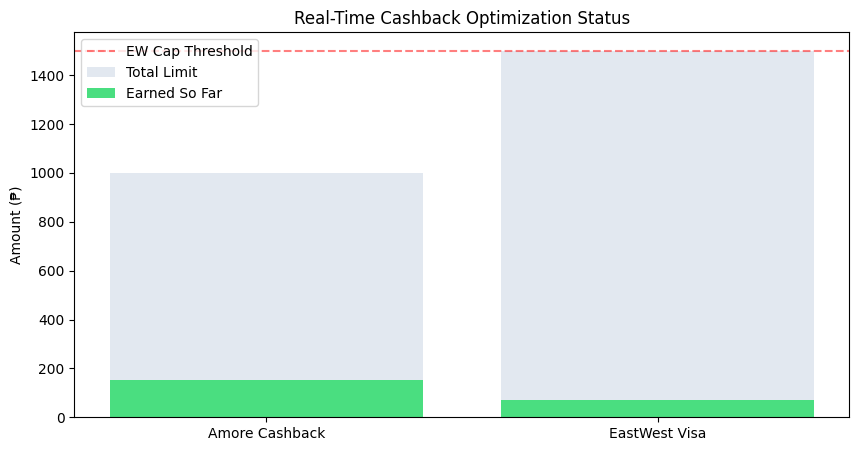

In [27]:
# Query to get the current status of all wallets for the current month
query = """
    SELECT w.name, h.amount_earned, h.monthly_limit 
    FROM wallet_cashback_history h
    JOIN wallets w ON h.wallet_id = w.id
    WHERE h.month_year = strftime('%Y-%m', 'now')
"""

labels, earned, limits = [], [], []
with sqlite3.connect(DB_PATH) as conn:
    cursor = conn.cursor()
    cursor.execute(query)
    for row in cursor.fetchall():
        labels.append(row[0])
        earned.append(row[1])
        limits.append(row[2])

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(labels, limits, color='#e2e8f0', label='Total Limit')
plt.bar(labels, earned, color='#4ade80', label='Earned So Far')
plt.axhline(y=1500, color='red', linestyle='--', alpha=0.5, label='EW Cap Threshold')

plt.title("Real-Time Cashback Optimization Status")
plt.ylabel("Amount (₱)")
plt.legend()
plt.show()

In [28]:
def fetch_chart_data(query, params=()):
    """Execute a query and return data in a format Matplotlib loves."""
    with get_db_connection() as conn:
        cursor = conn.cursor()
        cursor.execute(query, params)
        data = cursor.fetchall()
        # Unzip the results: [(cat, total), ...] -> ['cat1', 'cat2'], [100, 200]
        return zip(*data) if data else ([], [])

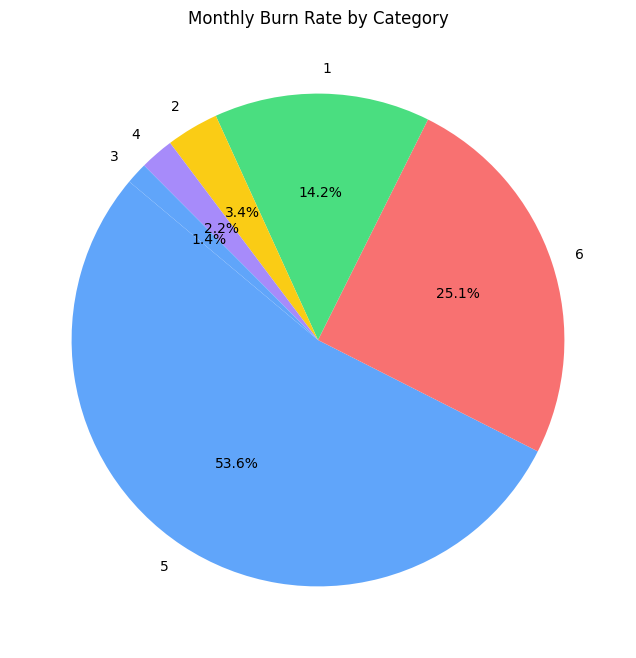

In [29]:
query = """
    SELECT d.category_id, SUM(d.line_amount) as total
    FROM transaction_details d
    GROUP BY d.category_id
    ORDER BY total DESC
"""

categories, totals = fetch_chart_data(query)

if categories:
    plt.figure(figsize=(8, 8))
    plt.pie(totals, labels=categories, autopct='%1.1f%%', startangle=140, 
            colors=['#60a5fa', '#f87171', '#4ade80', '#facc15', '#a78bfa'])
    plt.title("Monthly Burn Rate by Category")
    plt.show()
else:
    print("No transaction data found to plot.")